First we are going to load the data and visuaize the contents

In [49]:
import csv
import pandas as pd

data = pd.read_csv("data/in_silico_growth_curve.csv")
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

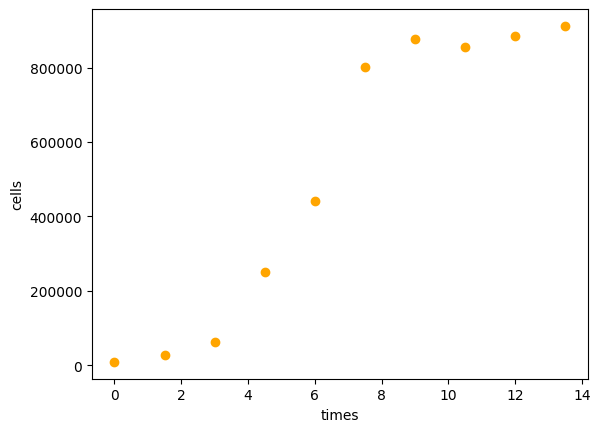

In [50]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])

However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

# Use of Biological Mechanistic knowledge. 
This data is a growth data of the cells where they consume nutrients and we can use the equations below for the basis of the model.

 
 $$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$
$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

 
 

# In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [51]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved_num_cells(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn))
    return sol[:,1]

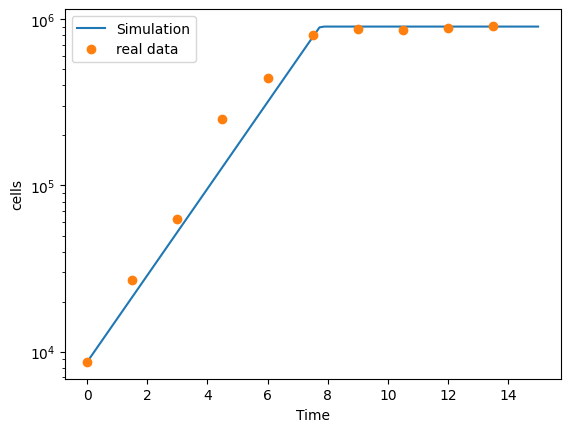

In [52]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved)
plt.plot(data['times'],data['cells'],'o')
plt.yscale('log')
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()

# Using pymc

In [53]:
import pymc as pm
from numba import njit

@njit
def cells_grow_pymc(y,t,theta):
    # unpack parameters
    N, P = y
    mu_max,Ks,Qn = theta
    
    dp_dt = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dq_dt = P*(mu_max*N)/(N+Ks)

    return [dp_dt, dq_dt]

y0 = [ 6e2, data['cells'][0] ]

In [54]:
# decorator with input and output types a Pytensor double float tensors
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))

# Slice Sampler: default

Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [mu_max]
>Slice: [Ks]
>Slice: [Qn]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 366 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_max,0.679,0.019,0.642,0.714,0.000,0.000,7174.0,5064.0,1.0
Ks,0.090,0.010,0.070,0.107,0.000,0.000,8086.0,5388.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,8059.0,5041.0,1.0
sigma,0.156,0.051,0.080,0.244,0.001,0.001,3644.0,4222.0,1.0


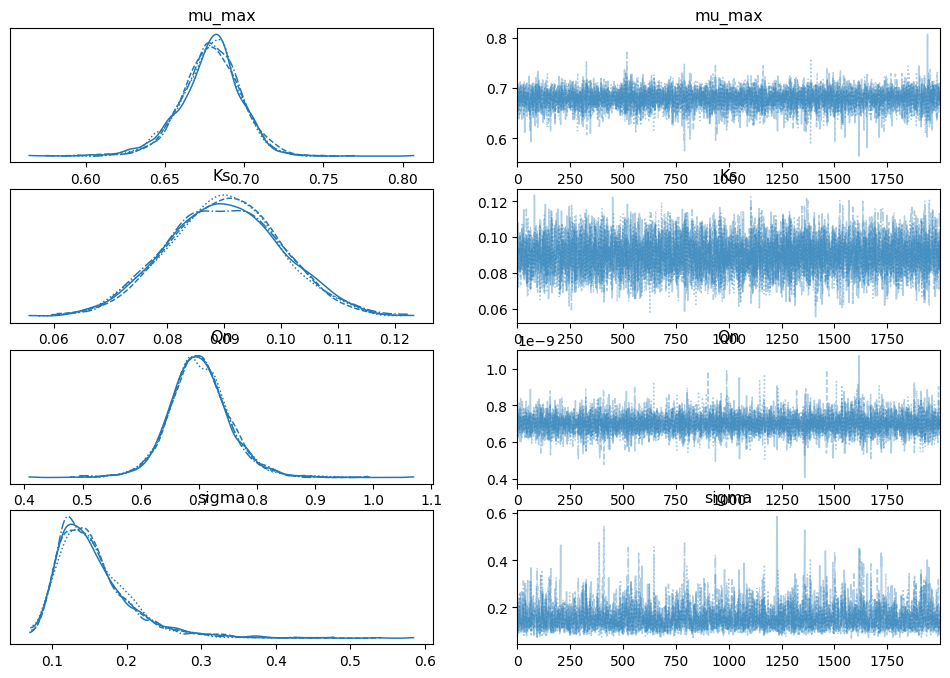

In [55]:
## Slice Sampler

with pm.Model() as model:
    # Priors
    
    
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace = pm.sample(2000, tune=1000,step=pm.Slice(), return_inferencedata=True, chains=4,cores=1)

# Summarize results
import arviz as az
print(trace)
az.plot_trace(trace)
az.summary(trace)



In [56]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["mu_max", "Ks", "Qn"]
    row = trace_df.iloc[row_idx, :][cols].values
  
    time = data['times']
    theta = row
    x_y = odeint(func= cells_grow_pymc, y0 = [ 6e2, data['cells'][0] ], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [57]:
def plot_inference(
    ax,
    trace,
    num_samples=200,
    title="Cell growth Bayesian fit",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [58]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="cells growth"):
    ax.plot(data['times'], data['cells'], color="k", lw=lw, marker="o", markersize=12, label="data")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cells", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

In [59]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=data['times'],
    alpha=1,
    lw=3,
    title="bayesian",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Bayesian")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.set_yscale('log')
    return ax

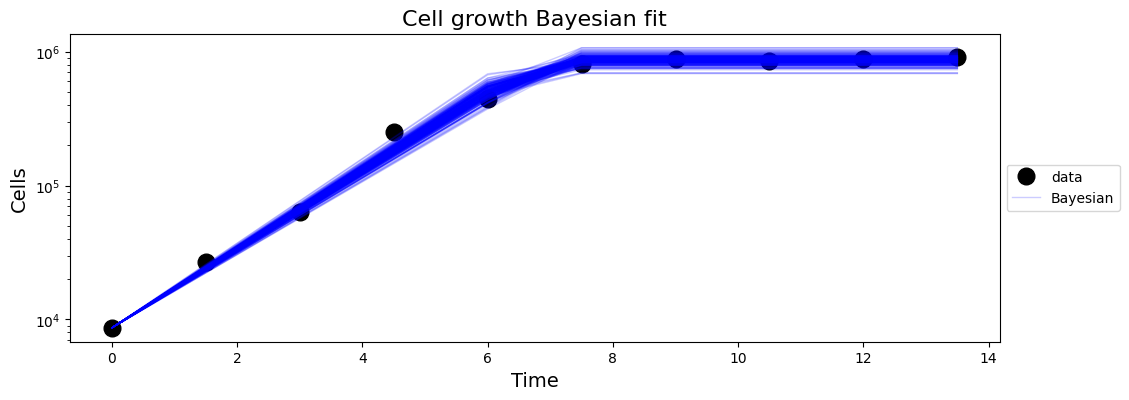

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

# DEMetropolisZ Sampler: a differential evolution Metropolis sampler that uses the past to inform sampling jumps

Sequential sampling (2 chains in 1 job)
DEMetropolisZ: [mu_max, Ks, Qn, sigma]


Sampling 2 chains for 8_000 tune and 2_000 draw iterations (16_000 + 4_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_max,0.681,0.019,0.647,0.715,0.001,0.001,213.0,251.0,1.01
Ks,0.090,0.011,0.071,0.110,0.001,0.000,237.0,221.0,1.01
Qn,0.000,0.000,0.000,0.000,0.000,0.000,235.0,241.0,1.01
sigma,0.158,0.048,0.084,0.249,0.003,0.002,268.0,372.0,1.01


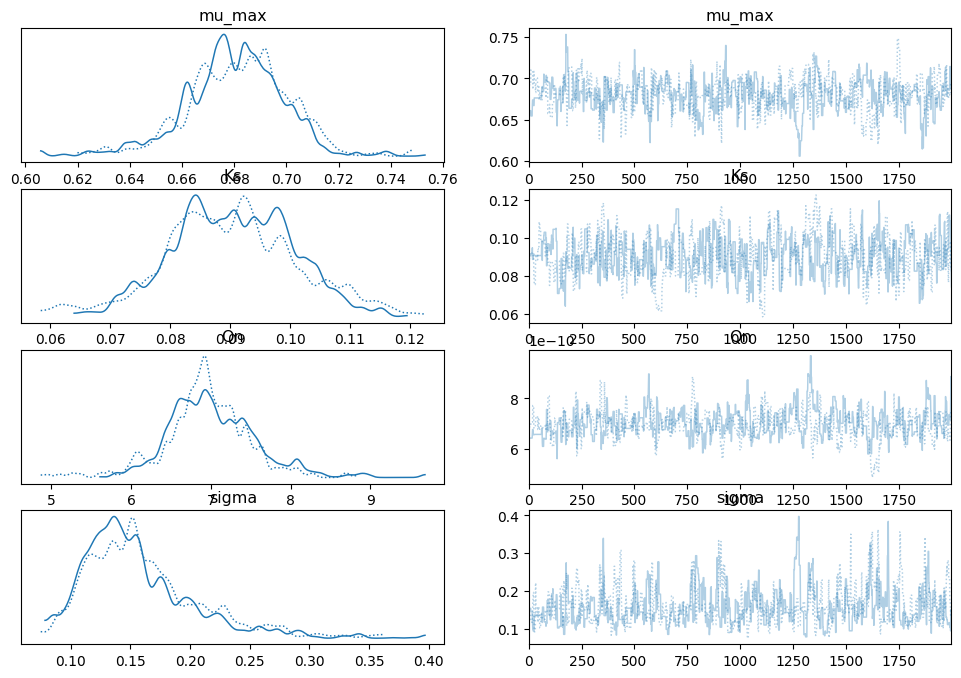

In [26]:
with pm.Model() as model_mz_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace = pm.sample(2000, tune=8000,step=pm.DEMetropolisZ(), return_inferencedata=True, cores=1)


# Summarize results
az.plot_trace(trace)
az.summary(trace)

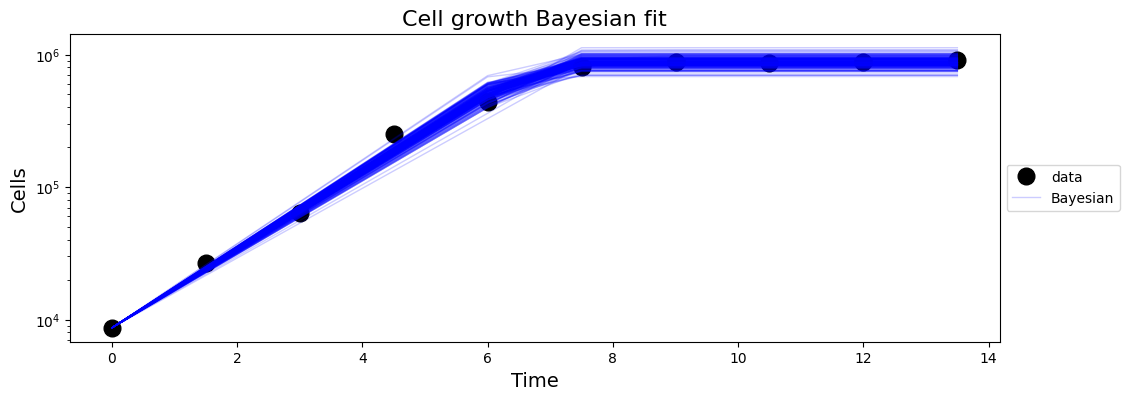

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);

# Metropolis Sampler

In [28]:
with pm.Model() as model_vaniallametro_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace_metropolis = pm.sample(2000, tune=2000,step=pm.Metropolis(), return_inferencedata=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu_max]
>Metropolis: [Ks]
>Metropolis: [Qn]
>Metropolis: [sigma]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_max,0.677,0.017,0.640,0.701,0.002,0.002,71.0,14.0,1.06
Ks,0.089,0.010,0.071,0.109,0.000,0.000,767.0,628.0,1.00
Qn,0.000,0.000,0.000,0.000,0.000,0.000,361.0,350.0,1.02
sigma,0.156,0.050,0.083,0.245,0.004,0.003,219.0,313.0,1.01


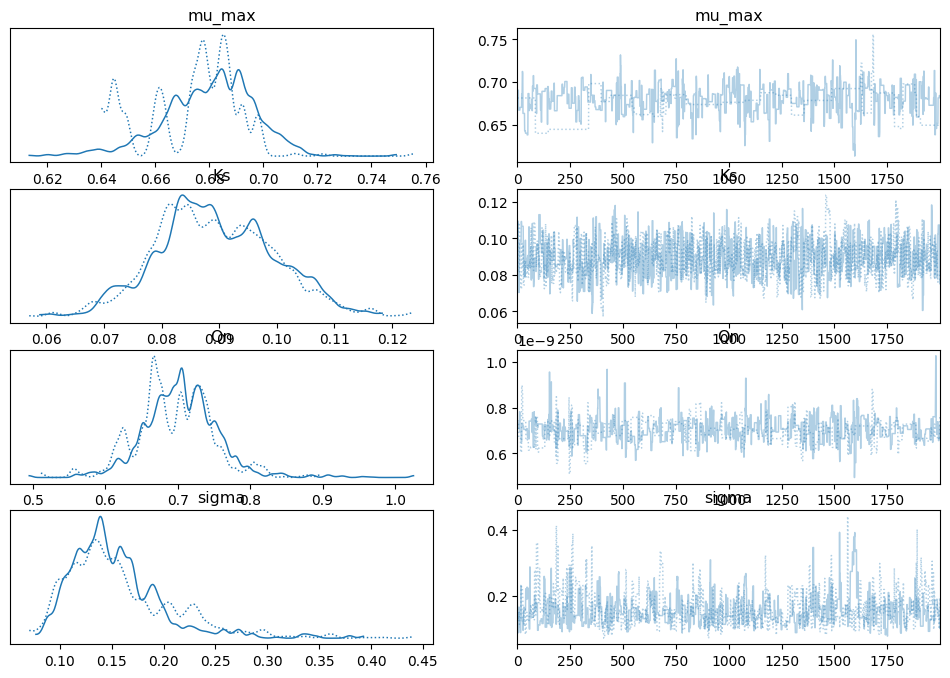

In [29]:
# Summarize results
az.plot_trace(trace_metropolis)
az.summary(trace_metropolis)

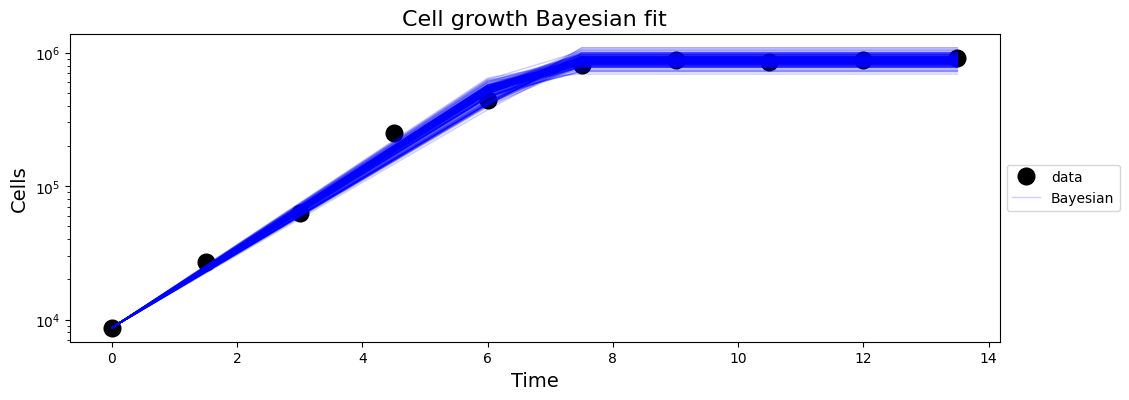

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace_metropolis,num_samples=200);

# NUTS classic

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>NUTS: [sigma]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 150 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_max,0.679,0.019,0.641,0.712,0.000,0.000,2526.0,1646.0,1.0
Ks,0.090,0.010,0.073,0.110,0.000,0.000,2916.0,1971.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,3034.0,2081.0,1.0
sigma,0.155,0.047,0.084,0.240,0.002,0.001,937.0,1141.0,1.0


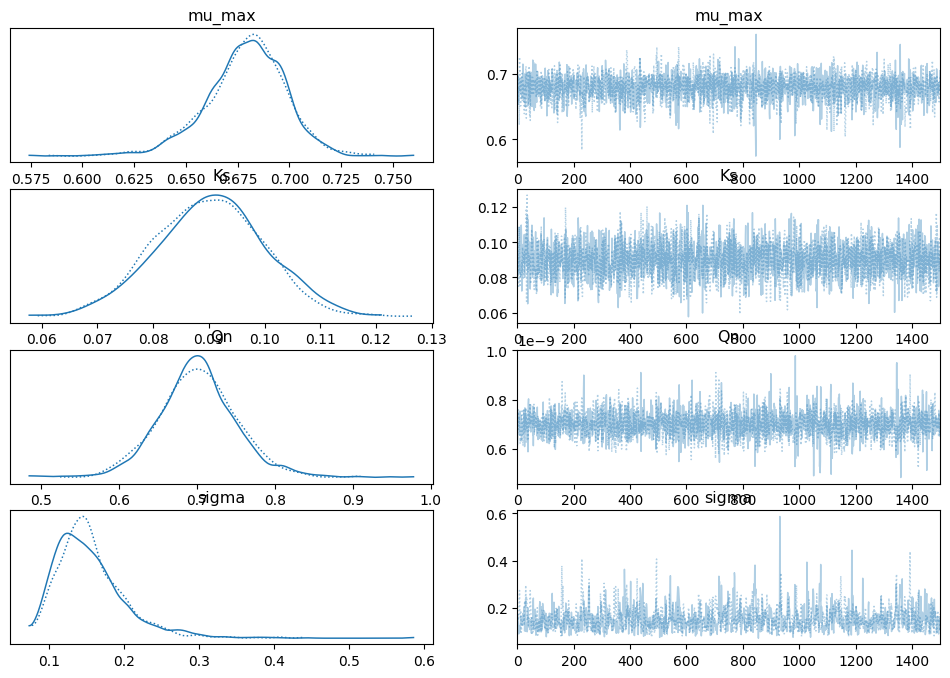

In [31]:
with pm.Model() as model_nuts_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))

sampler = "NUTS PyMC ODE"
tune = draws = 1500
with model_nuts_sampler:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, cores=1)

# Summarize results
az.plot_trace(trace_pymc_ode)
az.summary(trace_pymc_ode)

In [32]:
with pm.Model() as model_nuts_sampler:
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.06)
    Ks = pm.TruncatedNormal('Ks', mu=0.09, sigma=0.01,  lower=0.05, upper=0.13) 
    #I had to use the truncation, else the proposal samples would go to infeasible values. (Ks<0) and there will be no ODE solutions.
    
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))

sampler = "NUTS"
tune = draws = 1500
with model_nuts_sampler:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>NUTS: [sigma]


Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 145 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [33]:
# 1. Save the chains in a CSV file
# Convert the trace to a DataFrame and save it
import arviz as az

#df_trace = pm.trace_to_dataframe(trace_pymc_ode)
df_trace = az.convert_to_inference_data(obj=trace_pymc_ode).to_dataframe(include_coords=False,groups='posterior')
df_trace
df_trace.to_csv('trace_pymc_ode_init_fixed_compound_sampler.csv', index=False)

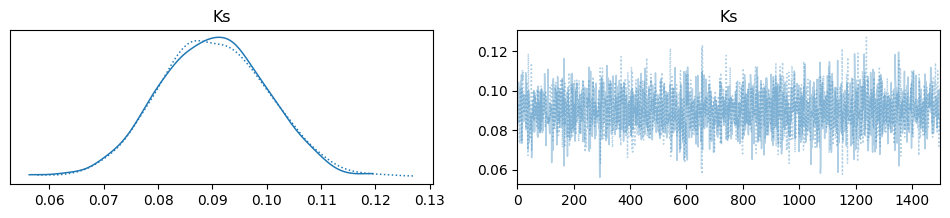

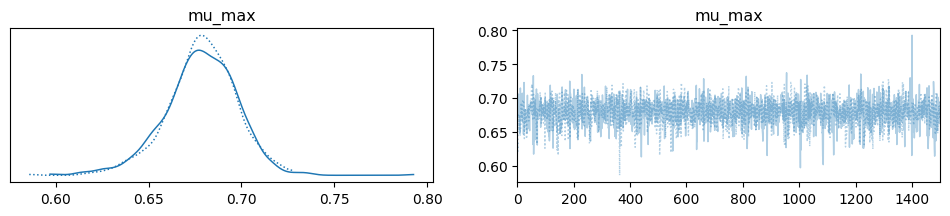

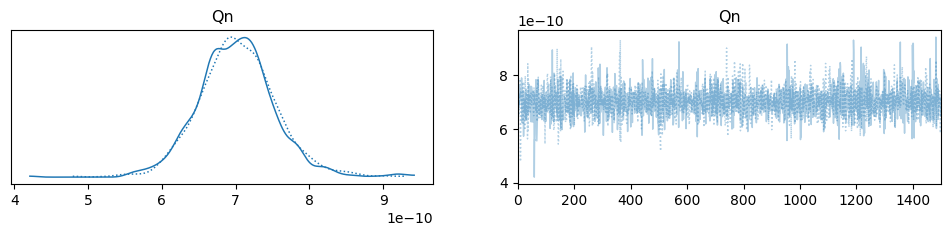

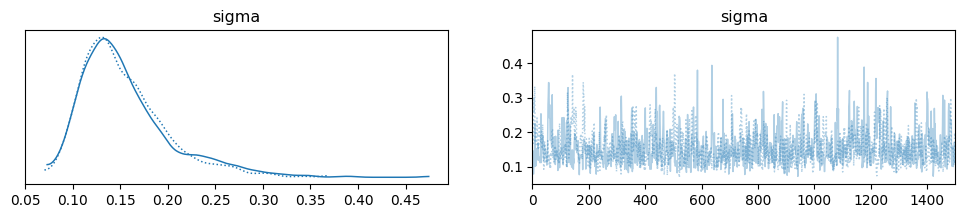

In [34]:
# 2. Plot trace plots for the chains
az.plot_trace(trace_pymc_ode,compact='False',var_names=("Ks"))
plt.show()
az.plot_trace(trace_pymc_ode,compact='False',var_names=("mu_max"))
plt.show()
az.plot_trace(trace_pymc_ode,compact='False',var_names=("Qn"))
plt.show()
az.plot_trace(trace_pymc_ode,compact='False',var_names=("sigma"))
plt.show()

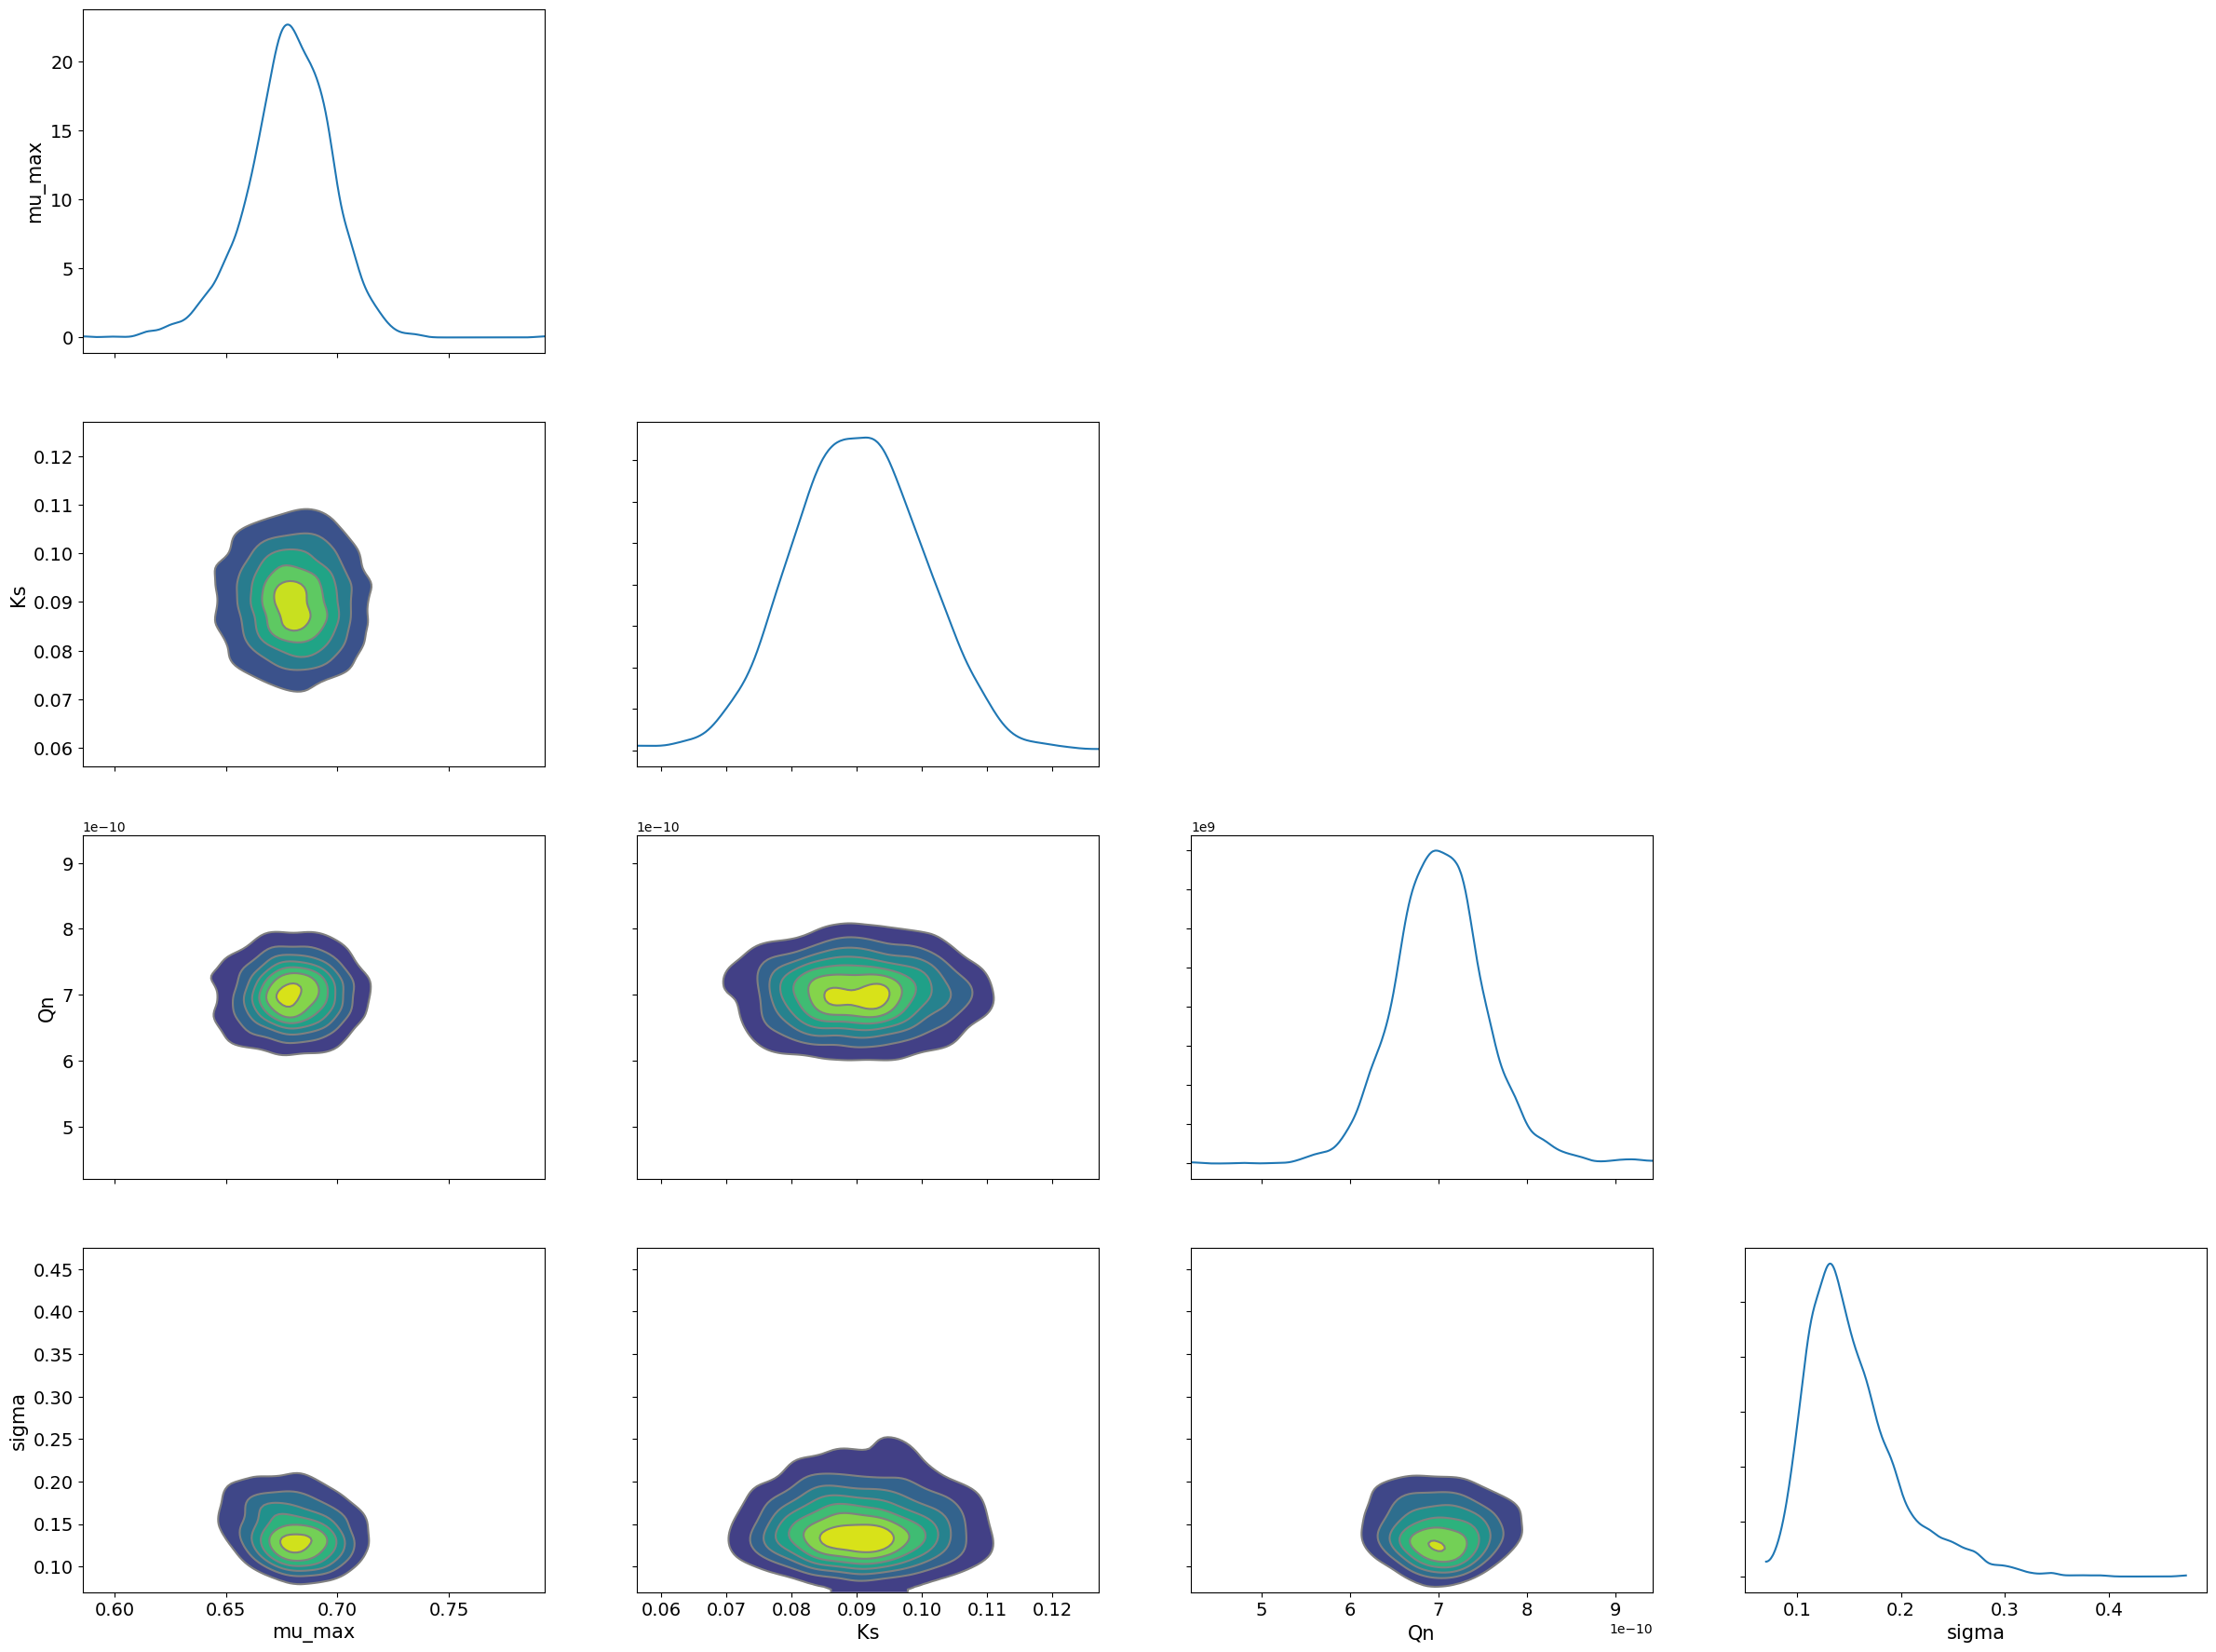

In [35]:
# 3. Plot covariance for the chains
az.plot_pair(trace_pymc_ode, kind='kde', divergences=True, marginals=True)
plt.show()

Rhat:
<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu_max   float64 1.002
    Ks       float64 1.001
    Qn       float64 1.0
    sigma    float64 1.003



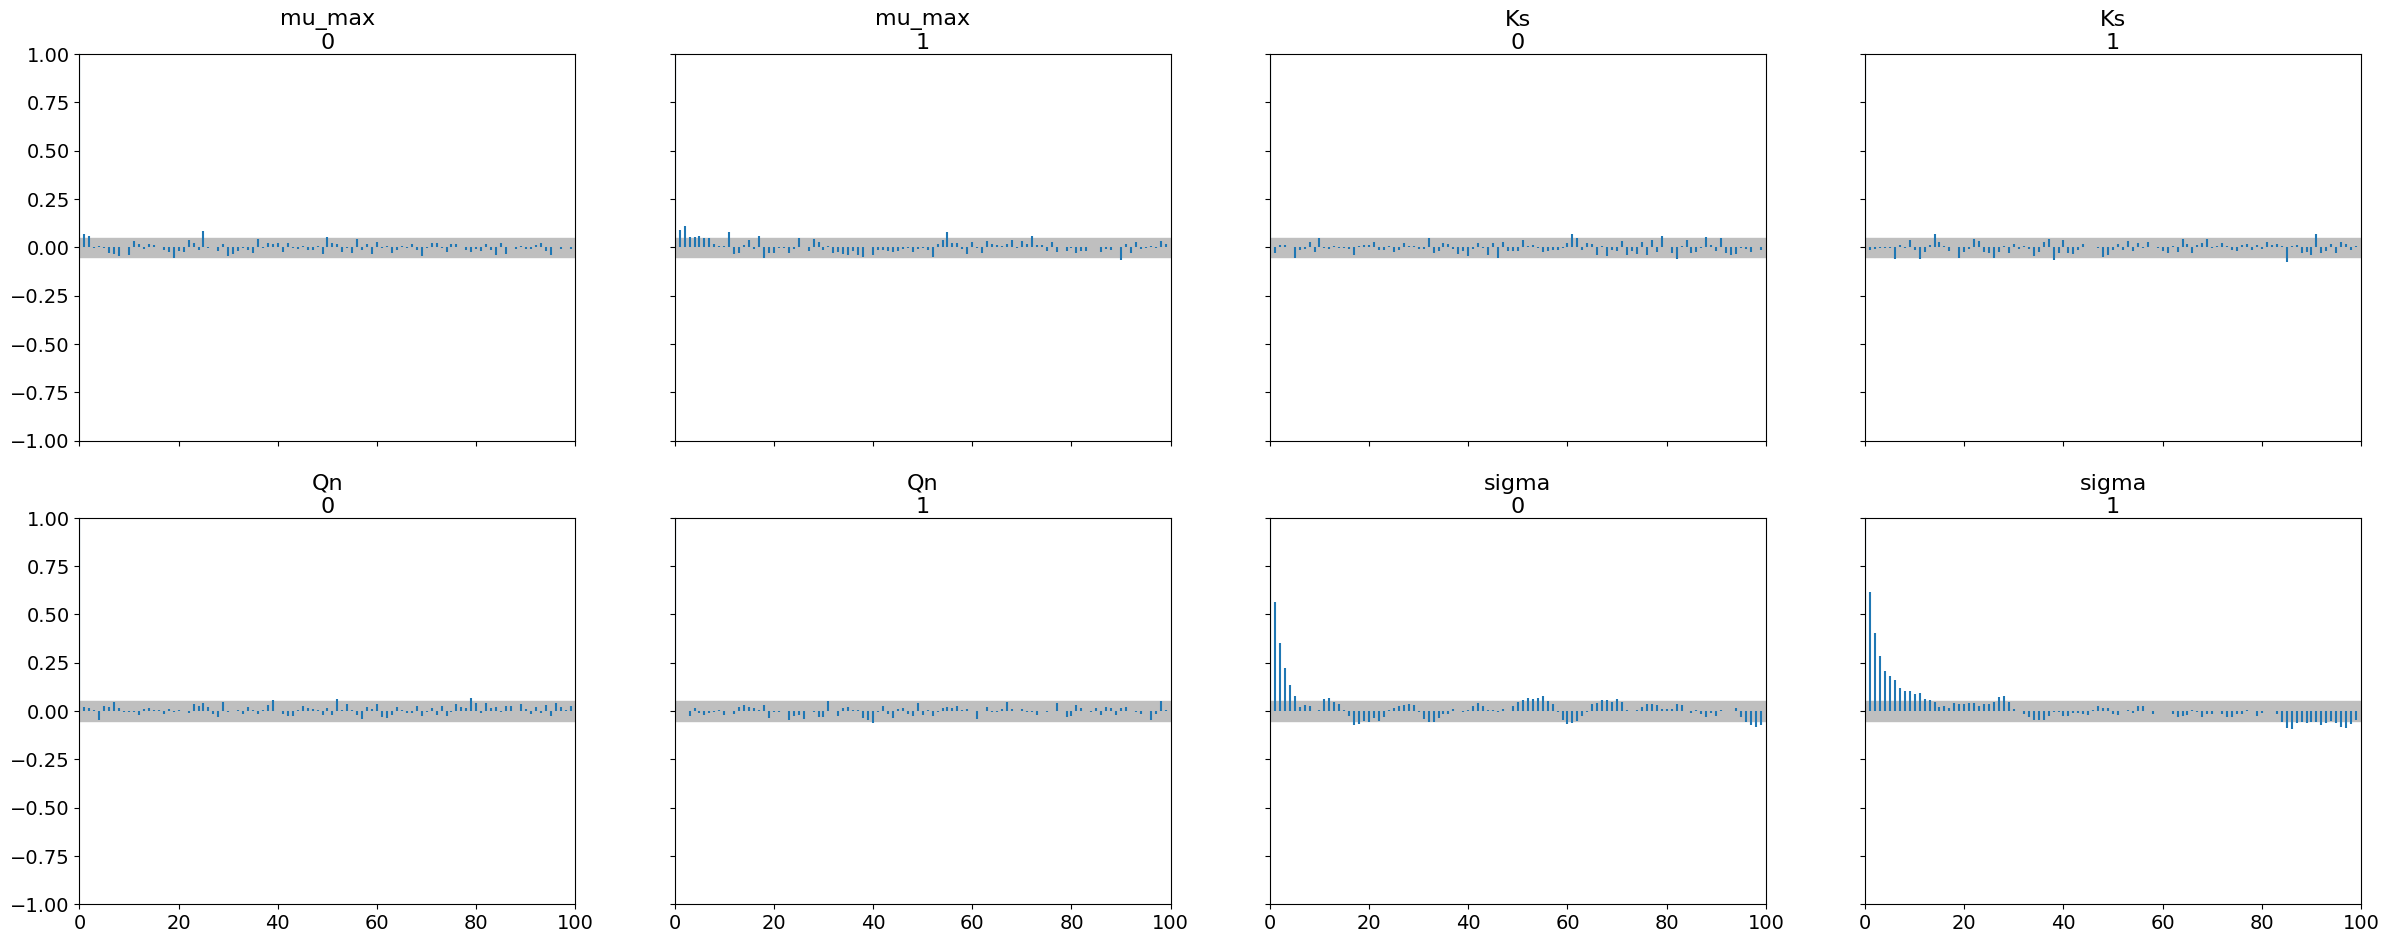

In [36]:
# 4. Convergence test for the chains - Gelman-Rubin, Geweke, and Autocorrelation
rhat = az.rhat(trace_pymc_ode)
#geweke = az.geweke(trace_pymc_ode)
autocorr = az.plot_autocorr(trace_pymc_ode)
print(f'Rhat:\n{rhat}\n')

In [37]:
# 5. Display other important statistics
summary = az.summary(trace_pymc_ode)
print(summary)

# Extract acceptance rates, burn length, etc.
burn_in_length = tune  # Assuming 'tune' variable represents burn-in length
acceptance_rate = trace_pymc_ode.get_sampler_stats('mean_tree_accept', combine=True)

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_max  0.678  0.019   0.641    0.713      0.000    0.000    2144.0    1657.0   
Ks      0.090  0.010   0.073    0.109      0.000    0.000    3124.0    2127.0   
Qn      0.000  0.000   0.000    0.000      0.000    0.000    2979.0    1654.0   
sigma   0.154  0.047   0.084    0.248      0.002    0.001     645.0    1145.0   

        r_hat  
mu_max    1.0  
Ks        1.0  
Qn        1.0  
sigma     1.0  


AttributeError: 'InferenceData' object has no attribute 'get_sampler_stats'

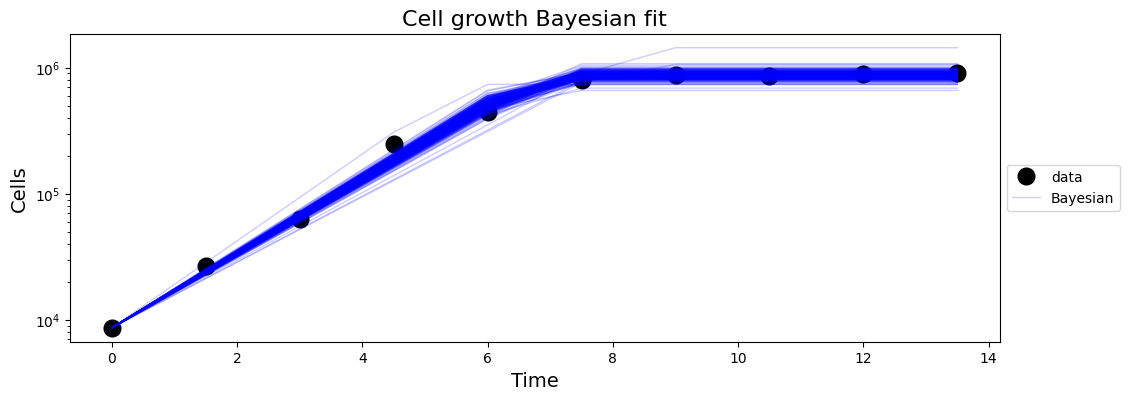

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace_pymc_ode,num_samples=200);